<a href="https://colab.research.google.com/github/LuizCarls/ML_Modelo_Cance_de_Mama/blob/main/ML_Modelo_Cance_de_Mama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando as Bibliotecas

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Carga do Dataset

In [ ]:
# Carregando dataset de câncer de mama
data = load_breast_cancer()
dataset = pd.DataFrame(data.data, columns=data.feature_names)
X = dataset[['mean area', 'mean perimeter', 'mean texture', 'mean radius']]  # Selecionando apenas os 4 atributos
y = data.target

# Mostra as primeiras linhas do dataset
dataset.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Separação em conjunto de treino e conjunto de teste com holdout

In [ ]:
# Definindo o tamanho do conjunto de teste e a semente aleatória
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                  shuffle=True, random_state=seed, stratify=y)

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)

# Modelagem e Inferência

### Criação e avaliação de modelos: linha base

LR: 0.918551 (0.042161)
KNN: 0.892174 (0.043597)
CART: 0.874734 (0.040651)
NB: 0.881063 (0.053852)
SVM: 0.878937 (0.044788)
Bagging: 0.892174 (0.042848)
RF: 0.896570 (0.042330)
ET: 0.898792 (0.042251)
Ada: 0.890048 (0.054134)
GB: 0.901063 (0.037446)
Voting: 0.905314 (0.043226)


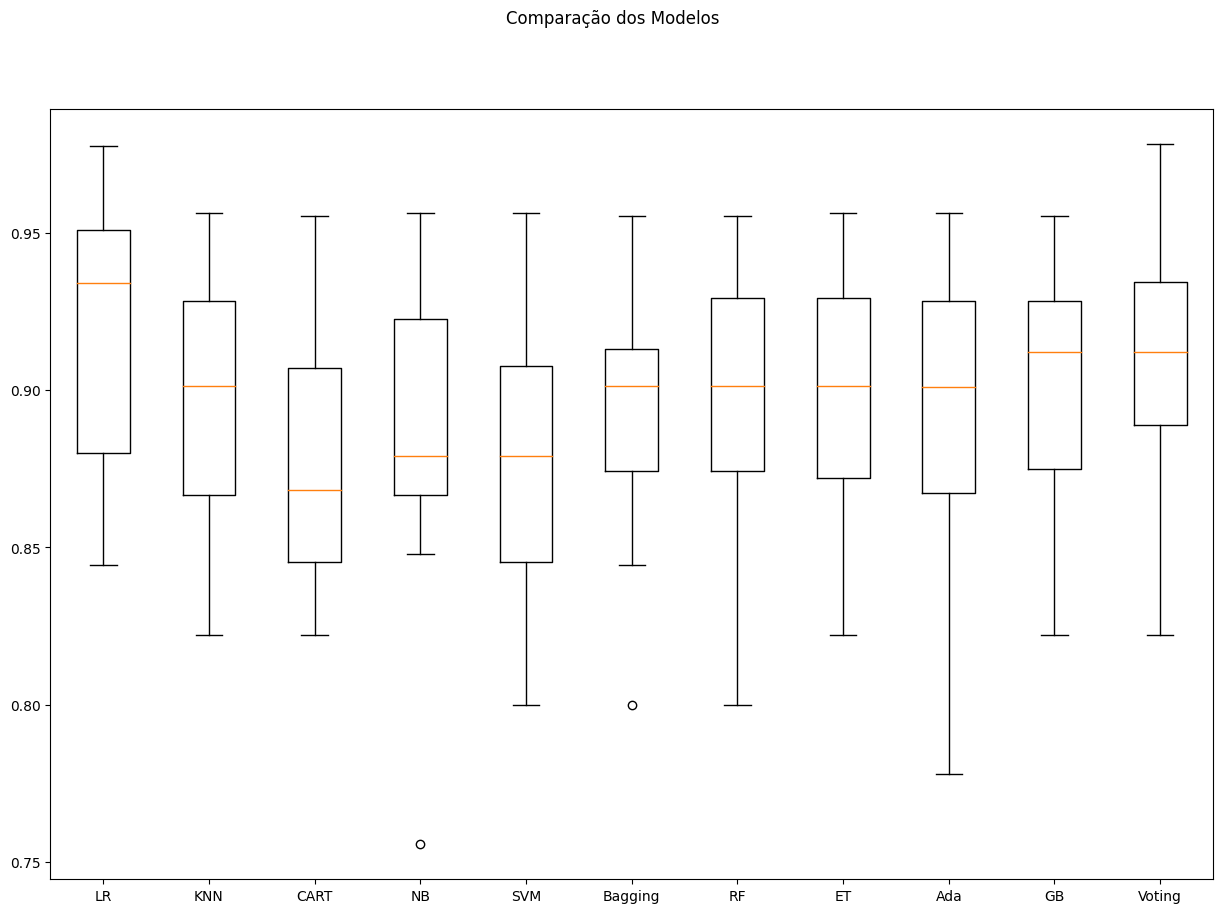

In [ ]:
np.random.seed(7) # Definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(estimators=bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Criação e avaliação de modelos: dados padronizados e normalizados

LR-orig: 0.919 (0.042)
KNN-orig: 0.892 (0.044)
CART-orig: 0.875 (0.041)
NB-orig: 0.881 (0.054)
SVM-orig: 0.879 (0.045)
Bag-orig: 0.892 (0.043)
RF-orig: 0.897 (0.042)
ET-orig: 0.899 (0.042)
Ada-orig: 0.890 (0.054)
GB-orig: 0.901 (0.037)
Vot-orig: 0.905 (0.043)
LR-padr: 0.899 (0.051)
KNN-padr: 0.894 (0.036)
CART-padr: 0.884 (0.040)
NB-padr: 0.881 (0.054)
SVM-padr: 0.905 (0.040)
Bag-padr: 0.899 (0.041)
RF-padr: 0.908 (0.043)
ET-padr: 0.899 (0.037)
Ada-padr: 0.890 (0.054)
GB-padr: 0.899 (0.040)
Vot-padr: 0.905 (0.036)
LR-norm: 0.886 (0.037)
KNN-norm: 0.901 (0.035)
CART-norm: 0.866 (0.051)
NB-norm: 0.881 (0.054)
SVM-norm: 0.905 (0.040)
Bag-norm: 0.894 (0.034)
RF-norm: 0.894 (0.046)
ET-norm: 0.901 (0.048)
Ada-norm: 0.890 (0.054)
GB-norm: 0.899 (0.040)
Vot-norm: 0.894 (0.037)


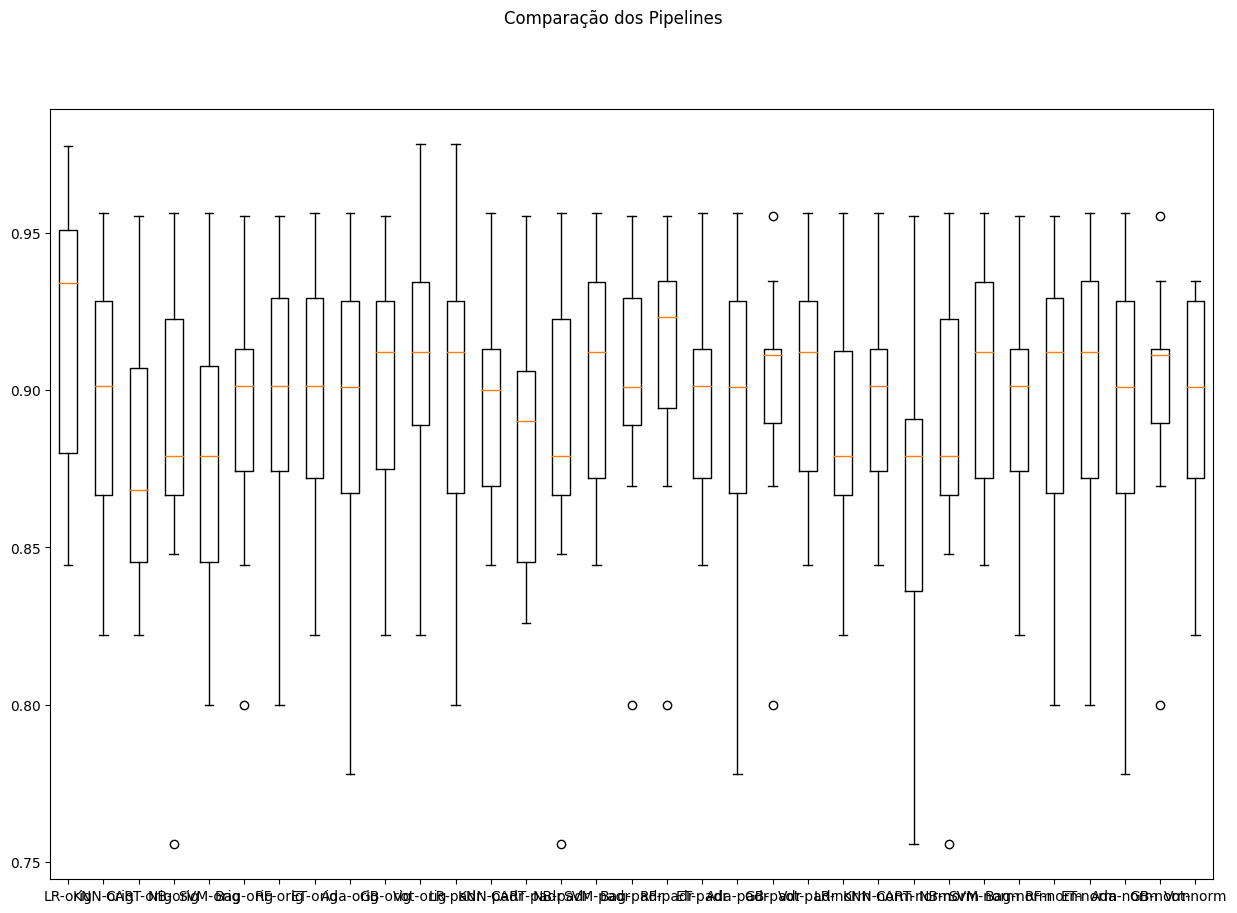

In [ ]:
np.random.seed(7) # Definindo uma semente global para este bloco

# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(estimators=bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos pipelines
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Pipelines')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Otimização dos hiperparâmetros

In [ ]:
# Tuning do KNN
np.random.seed(7) # Definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [3, 5, 7, 9],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Executando o tuning
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.892174 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 5}
Sem tratamento de missings: knn-padr - Melhor: 0.907633 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 3}
Sem tratamento de missings: knn-norm - Melhor: 0.907536 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 3}


# Finalização do Modelo

In [ ]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train)  # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train)  # aplicação da padronização no conjunto de treino
model = LogisticRegression(max_iter=200)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test)  # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print("Acurácia no conjunto de teste:", accuracy_score(y_test, predictions))

Acurácia no conjunto de teste: 0.8859649122807017


In [ ]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X)  # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X)  # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

LogisticRegression(max_iter=200)

# Simulando a aplicação do modelo em dados não vistos

In [ ]:
# Ajustando os novos dados para ter os mesmos nomes de colunas que no treinamento
data = {
    'mean area': [500.0, 550.0, 480.0],
    'mean perimeter': [90.0, 100.0, 85.5],
    'mean texture': [20.5, 22.0, 21.3],
    'mean radius': [14.0, 15.5, 13.7],
}

# Verificar as colunas utilizadas no treinamento
atributos = ['mean area', 'mean perimeter', 'mean texture', 'mean radius']
entrada = pd.DataFrame(data, columns=atributos)

# Convertendo para DataFrame e garantindo a ordem correta das colunas
df_novos_dados = pd.DataFrame(novos_dados)
df_novos_dados = df_novos_dados[atributos_usados]  # Reordenar as colunas para corresponder à ordem de treinamento

array_entrada = entrada.values
X_entrada = array_entrada[:,0:8].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)


[[-0.4405205  -0.08110488  0.28165692 -0.03615266]
 [-0.29831537  0.33079712  0.63071699  0.38986863]
 [-0.49740256 -0.26646078  0.46782229 -0.12135692]]


In [ ]:
# Fazendo a predição com o melhor modelo
saidas = model.predict(rescaledEntradaX)

# Imprimindo resultados
print("Predições para os novos dados: ", saidas)

Predições para os novos dados:  [1 0 1]
